In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
plt.style.use('seaborn-white')
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Input, LSTM, TimeDistributed, LSTMCell
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from pyts.image import GramianAngularField
from scipy.io import wavfile
import scipy.signal as signal
from PIL import Image
import glob
from sklearn.model_selection import train_test_split
import keras
from keras.utils import np_utils
import random
from scipy import signal

2022-05-10 20:42:10.825397: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# 폴더 내 파일 개수 반환
def get_files_count(path):
    count = 0    
    for path in os.listdir(path):
        count += 1
    return count

In [3]:
def my_seed_everywhere(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # np
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    tf.random.set_seed(seed) # tensorflow

my_seed = 42
my_seed_everywhere(my_seed)

# MIMII → 32x32 image(Spectro)

In [4]:
#abnormal
am_list = []
data_path = f"../data/mimii-anomaly-detection/0_dB/pump/id_00/abnormal"
filelist = sorted(glob.glob(f'{data_path}/*.wav'))
for i in range(get_files_count(data_path)-1):
    samrate, data = wavfile.read(f"{filelist[i]}")#wav read
    frequencies, times, spectrogram = signal.spectrogram(data[:,2], samrate)
    #Main mic
    #fan.5번(4) pump.3번(2) valve.1번(0) slider.7번(6)
    img = Image.fromarray(spectrogram)
    img = img.resize((32,32), Image.ANTIALIAS)
    spectrogram = np.array(img)
    am_list.append(spectrogram)#data save


/tmp/ipykernel_3001199/2446440696.py:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((32,32), Image.ANTIALIAS)


In [5]:
#normal
nm_list = []
data_path = f"../data/mimii-anomaly-detection/0_dB/pump/id_00/normal"
filelist = sorted(glob.glob(f'{data_path}/*.wav'))
for i in range(get_files_count(data_path)-1):
    samrate, data = wavfile.read(f"{filelist[i]}")#wav read
    frequencies, times, spectrogram = signal.spectrogram(data[:,2], samrate)
    #Main mic
    #fan.5번(4) pump.3번(2) valve.1번(0) slider.7번(6)
    img = Image.fromarray(spectrogram)
    img = img.resize((32,32), Image.ANTIALIAS)
    spectrogram = np.array(img)
    nm_list.append(spectrogram)#data save



/tmp/ipykernel_3001199/837896892.py:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((32,32), Image.ANTIALIAS)


In [6]:
Normal = np.array(nm_list)
Abnormal = np.array(am_list)

# 라벨링, 정상: 0, 비정상: 1
normal_Y = np.zeros((Normal.shape[0], 1))
abnormal_Y = np.ones((Abnormal.shape[0], 1))

print(normal_Y.shape)
print(abnormal_Y.shape)

X = np.concatenate((Normal,Abnormal))
Y = np.concatenate((normal_Y,abnormal_Y))

print(X.shape)
print(Y.shape)

(1005, 1)
(142, 1)
(1147, 32, 32)
(1147, 1)


In [7]:
X_train,X_test,Y_train,Y_test=train_test_split(X, Y ,test_size=0.2,shuffle=True, stratify=Y, random_state=my_seed)

X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.2, shuffle=True, stratify=Y_test, random_state=my_seed)


X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 1)

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_val = X_val.astype('float32') / 255.


#X_train = (X_train - np.min(X_train)) / (np.max(X_train)- np.min(X_train))
#X_test = (X_test - np.min(X_test)) / (np.max(X_test)- np.min(X_test))
#X_val = (X_val - np.min(X_val)) / (np.max(X_val)- np.min(X_val))

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_test.shape)
print(Y_val.shape)



(917, 32, 32, 1)
(184, 32, 32, 1)
(46, 32, 32, 1)
(917, 1)
(184, 1)
(46, 1)


In [8]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(32,32,1), activation='relu', padding='same'))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(64,return_sequences=True, recurrent_activation='sigmoid'))
model.add(LSTM(64,return_sequences=True, recurrent_activation='sigmoid'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr=0.001),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='loss', mode='min', patience=20)
model.summary()



2022-05-10 20:42:16.723596: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-05-10 20:42:16.766696: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-05-10 20:42:16.767374: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:65:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-05-10 20:42:16.767407: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-05-10 20:42:16.769288: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcu

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0

/media/sda1/anaconda3/envs/cnn-autoencoder/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [9]:
history = model.fit(X_train, Y_train, epochs=1000, validation_data=(X_test, Y_test), batch_size = 16, callbacks=[early_stopping])

2022-05-10 20:42:18.127908: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-10 20:42:18.146820: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 4099895000 Hz


Epoch 1/1000


2022-05-10 20:42:20.055037: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-05-10 20:42:20.605653: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2022-05-10 20:42:21.375117: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-05-10 20:42:21.375142: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2022-05-10 20:42:21.375219: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-05-10 20:42:21.417022: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-05-10 20:42:21.930701: I tensorflow/stream_exec

58/58 [==============================] - 6s 21ms/step - loss: 0.3247 - accuracy: 0.9079 - val_loss: 0.1927 - val_accuracy: 0.9497
Epoch 2/1000
58/58 [==============================] - 1s 10ms/step - loss: 0.2050 - accuracy: 0.9489 - val_loss: 0.2317 - val_accuracy: 0.9457
Epoch 3/1000
58/58 [==============================] - 1s 10ms/step - loss: 0.1998 - accuracy: 0.9500 - val_loss: 0.2036 - val_accuracy: 0.9477
Epoch 4/1000
58/58 [==============================] - 1s 11ms/step - loss: 0.1888 - accuracy: 0.9549 - val_loss: 0.1835 - val_accuracy: 0.9524
Epoch 5/1000
58/58 [==============================] - 1s 11ms/step - loss: 0.1916 - accuracy: 0.9527 - val_loss: 0.2196 - val_accuracy: 0.9457
Epoch 6/1000
58/58 [==============================] - 1s 11ms/step - loss: 0.2291 - accuracy: 0.9468 - val_loss: 0.1921 - val_accuracy: 0.9511
Epoch 7/1000
58/58 [==============================] - 1s 11ms/step - loss: 0.1764 - accuracy: 0.9535 - val_loss: 0.2299 - val_accuracy: 0.9504
Epoch 8/1000

58/58 [==============================] - 1s 11ms/step - loss: 0.0320 - accuracy: 0.9915 - val_loss: 0.1481 - val_accuracy: 0.9810
Epoch 59/1000
58/58 [==============================] - 1s 11ms/step - loss: 0.0218 - accuracy: 0.9943 - val_loss: 0.1274 - val_accuracy: 0.9823
Epoch 60/1000
58/58 [==============================] - 1s 11ms/step - loss: 0.0400 - accuracy: 0.9887 - val_loss: 0.1082 - val_accuracy: 0.9776
Epoch 61/1000
58/58 [==============================] - 1s 11ms/step - loss: 0.0227 - accuracy: 0.9963 - val_loss: 0.1452 - val_accuracy: 0.9817
Epoch 62/1000
58/58 [==============================] - 1s 10ms/step - loss: 0.0446 - accuracy: 0.9879 - val_loss: 0.1091 - val_accuracy: 0.9783
Epoch 63/1000
58/58 [==============================] - 1s 11ms/step - loss: 0.0405 - accuracy: 0.9911 - val_loss: 0.0878 - val_accuracy: 0.9864
Epoch 64/1000
58/58 [==============================] - 1s 10ms/step - loss: 0.0467 - accuracy: 0.9851 - val_loss: 0.1803 - val_accuracy: 0.9640
Epoch 

In [10]:
(test_loss, test_acc) = model.evaluate(X_test,  Y_test, verbose=2)
print('\n테스트 정확도:', test_acc)

6/6 - 0s - loss: 0.1412 - accuracy: 0.9776

테스트 정확도: 0.9775815010070801


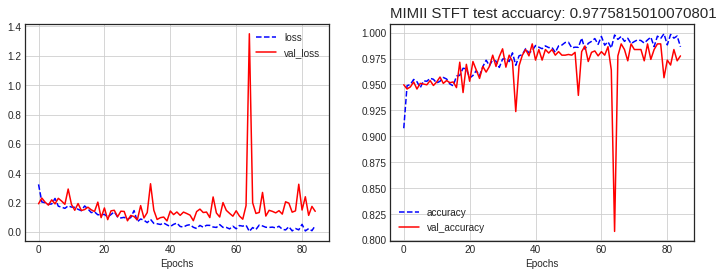

In [11]:
history.history.keys()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b--', label='loss')
plt.plot(history.history['val_loss'], 'r', label='val_loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'b--', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r', label='val_accuracy')
plt.xlabel('Epochs')
plt.title(f"MIMII STFT test accuarcy: {test_acc}", loc='left', fontdict = {'fontsize' : 15})
plt.grid()
plt.legend()


plt.show()

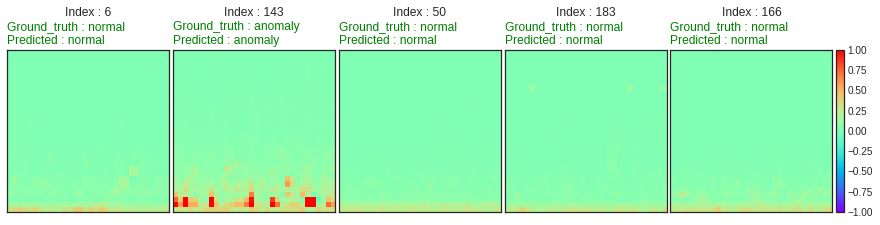

In [17]:
from mpl_toolkits.axes_grid1 import ImageGrid
random_list = random.sample(range(Y_test.size), 5)

fig = plt.figure(figsize=(15, 15))
grid = ImageGrid(fig, 111, nrows_ncols=(1,5), axes_pad=0.05, share_all=True, cbar_mode='single')
y_predicted = (model.predict(X_test) > 0.5).astype("int32")

i = 0
for ax, im in zip(grid, [X_test[random_list[0]], X_test[random_list[1]], X_test[random_list[2]], X_test[random_list[3]], X_test[random_list[4]]]):
    ground_truth = 'anomaly' if Y_test[random_list[i]][0] == 1.0 else 'normal'
    predicted = 'anomaly' if y_predicted[random_list[i]][0] == 1.0 else 'normal'
    color = 'g' if ground_truth == predicted else 'r'
    ax.set_title(f"Index : {random_list[i]}\n\n", loc='center')
    ax.set_title(f"Ground_truth : {ground_truth}\nPredicted : {predicted}", loc='left', color=color)
    im = ax.imshow(im, cmap='rainbow', origin='lower', vmin=-1., vmax=1.)
    i = i+1
    
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
plt.colorbar(im, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)

plt.show()

In [13]:

from sklearn import metrics
print(y_predicted.shape)
y_predicted=y_predicted[:,1]
print('precision:', metrics.precision_score(Y_test, y_predicted,pos_label=0))
print('recall:',metrics.recall_score(Y_test, y_predicted,pos_label=0))
print('f1_score:', metrics.f1_score(Y_test, y_predicted,pos_label=0))

(184, 8, 1)
precision: 0.9876543209876543
recall: 0.9876543209876543
f1_score: 0.9876543209876543
